## Imports

In [1]:
import torch
from pathlib import Path
from models_mae_hetero import mae_vit_small_patch16
from dataset_classes.csi_sensing import CSISensingDataset
from dataset_classes.radio_sig import RadioSignal
from dataset_classes.ofdm_channel_estimation import OfdmChannelEstimation
from dataset_classes.positioning import Positioning5G
from dataset_classes.pretrain_csi_5g import CSI5G
from dataset_classes.pretrain_csi_wifi import CSIWiFi
from dataset_classes.spectrogram_images import SpectrogramImages
from torchvision import transforms
from torchvision.transforms import InterpolationMode
from torch.utils.data import DataLoader, SubsetRandomSampler
import umap
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, KernelPCA
import pandas as pd
from timm.models.vision_transformer import PatchEmbed
from torch.nn.functional import normalize
from scipy.linalg import sqrtm



## Helpers

In [2]:
def sample_batch(dataset, n, num_workers=0, pin_memory=True, seed=42):
    """
    Return a tensor with up to `n` randomly drawn examples (no labels).
    Reproducible when `seed` is set.
    """
    ds_len = len(dataset)

    # Set the seed for reproducibility
    g = torch.Generator()
    g.manual_seed(seed)

    # --- decide how many indices to draw ---------------------------------
    if n >= ds_len:
        indices = torch.randperm(ds_len, generator=g)
        batch_size = ds_len
        drop_last = False
    else:
        indices = torch.randperm(ds_len, generator=g)[:n]
        batch_size = n
        drop_last = True

    loader = DataLoader(
        dataset,
        batch_size=batch_size,
        sampler=SubsetRandomSampler(indices),
        drop_last=drop_last,
        num_workers=num_workers,
        pin_memory=pin_memory,
    )

    batch = next(iter(loader))

    if isinstance(batch, (list, tuple)):
        batch = batch[0]
    return batch


def generate_embeddings(model, x, patch_embed_weight, patch_embed_bias, block_idx=12):
    # embed patches
    c = x.shape[1]
    # idx = model.chan_mapping[c]
    # x = model.patch_embed[idx](x)
    ckpt = {'proj.weight': patch_embed_weight.clone().expand((512, c, 16, 16)), 'proj.bias': patch_embed_bias}
    patch_embed = PatchEmbed(224, 16, c, 512)
    patch_embed.load_state_dict(ckpt, strict=True)
    patch_embed = patch_embed.to(device)
    x = patch_embed(x)
    # add pos embed w/o cls token
    x = x + model.pos_embed[:, 1:, :]

    # append cls token
    cls_token = model.cls_token + model.pos_embed[:, :1, :]
    cls_tokens = cls_token.expand(x.shape[0], -1, -1)
    x = torch.cat((cls_tokens, x), dim=1)

    # apply Transformer blocks
    for blk in model.blocks[:block_idx]:
        x = blk(x)
    x = model.norm(x)

    return x

# ---------------------------------------------------------------
# Fréchet distance between two embedding sets
# ---------------------------------------------------------------
def frechet_distance(X, Y):
    mu_X = np.mean(X, axis=0)
    mu_Y = np.mean(Y, axis=0)
    cov_X = np.cov(X.T)
    cov_Y = np.cov(Y.T)
    cov_sqrt = sqrtm(cov_X @ cov_Y)
    if np.iscomplexobj(cov_sqrt):
        cov_sqrt = cov_sqrt.real
    dist_squared = np.sum((mu_X - mu_Y) ** 2) + np.trace(cov_X + cov_Y - 2 * cov_sqrt)
    return np.sqrt(dist_squared)

# cosine distance
def mean_cosine_distance(X, Y):
    Xn = torch.nn.functional.normalize(X, dim=1)
    Yn = torch.nn.functional.normalize(Y, dim=1)
    return (1.0 - Xn @ Yn.T).mean().item()   # 0 .. 2


def centroid_cosine_distance(X: torch.Tensor, Y: torch.Tensor) -> float:
    """
    Compute cosine distance between the centroids of two embedding clouds.
    Cosine distance = 1 - cosine_similarity(mu_X, mu_Y).
    X, Y: (N, D) and (M, D) tensors (no batch dimension).
    """
    # Compute centroids
    mu_x = X.mean(dim=0, keepdim=True)  # (1, D)
    mu_y = Y.mean(dim=0, keepdim=True)  # (1, D)

    # L2-normalize
    mu_x = normalize(mu_x, dim=1)       # (1, D)
    mu_y = normalize(mu_y, dim=1)       # (1, D)

    # Cosine similarity
    cos_sim = (mu_x @ mu_y.T).item()    # scalar in [-1, 1]

    # Convert to distance
    return 1.0 - cos_sim                 # 0 = identical, 2 = opposite

## Compute embeddings

In [3]:
dataset_wifi = CSIWiFi(Path('../datasets/NTU-Fi-HumanID/'))
dataset_5g = CSI5G(Path('../datasets/5G_CFR'))

transform_train = transforms.Compose([
    transforms.functional.pil_to_tensor,
    transforms.Lambda(lambda x: 10 * torch.log10(x + 1e-12)),
    transforms.Lambda(lambda x: (x + 120) / (-0.5 + 120)),
    transforms.Resize((224, 224), antialias=True,
                      interpolation=InterpolationMode.BICUBIC),  # Resize
    transforms.Normalize(mean=[0.451], std=[0.043])  # Normalize
])
dataset_spectro = SpectrogramImages(['..\\datasets\\spectrogram_dataset', '..\\datasets\\spectrogram_iqengine_dataset'],
                                    transform=transform_train)

# fine-tuning datasets
dataset_sensing = CSISensingDataset(Path('../datasets/NTU-Fi_HAR/train'))
dataset_positioning = Positioning5G(Path('../datasets/5G_NR_Positioning/outdoor/train'))
dataset_ce = OfdmChannelEstimation(Path('../datasets/channel_estimation_dataset_(5,10)/train_preprocessed'))
dataset_rf = RadioSignal(Path('../datasets/radio_sig_identification/train'))

# all data
datasets = {'RFS': dataset_spectro, 'WiFi-CSI': dataset_wifi, '5G-CSI': dataset_5g, 'sensing': dataset_sensing,
            'rf_classification': dataset_rf, 'positioning': dataset_positioning, 'channel_estimation': dataset_ce}

# models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ckpt = torch.load(Path('checkpoints/pretrained_all_data.pth'))['model']
model = mae_vit_small_patch16(in_chans=[1, 3, 4])
model.load_state_dict(ckpt, strict=True)
model = model.to(device)
patch_embed_weight = ckpt['patch_embed.0.proj.weight']
patch_embed_bias = ckpt['patch_embed.0.proj.bias']
model.eval()

# create patch embed
# patch_embed_sensing = PatchEmbed(224, 16, 3, 512)
# ckpt = torch.load('checkpoints/nice_ckpts/sensing.pth')['model']
# ckpt = {k[12:]: v for k, v in ckpt.items() if k.startswith('patch_embed')}
# patch_embed_sensing.load_state_dict(ckpt)
# patch_embed_positioning = PatchEmbed(224, 16, 4, 512)
# ckpt = torch.load('checkpoints/nice_ckpts/positioning.pth')['model']
# ckpt = {k[12:]: v for k, v in ckpt.items() if k.startswith('patch_embed')}
# patch_embed_positioning.load_state_dict(ckpt)
# patch_embed_rfsig = PatchEmbed(224, 16, 1, 512)
# ckpt = torch.load('checkpoints/nice_ckpts/rfsig.pth')['model']
# ckpt = {k[12:]: v for k, v in ckpt.items() if k.startswith('patch_embed')}
# patch_embed_rfsig.load_state_dict(ckpt)
# patch_embed_ce = PatchEmbed(224, 16, 2, 512)
# ckpt = torch.load('checkpoints/nice_ckpts/ce.pth')['model']
# ckpt = {k[12:]: v for k, v in ckpt.items() if k.startswith('patch_embed')}
# patch_embed_ce.load_state_dict(ckpt)


# patch_embed_sensing = patch_embed_sensing.to(device)
# patch_embed_sensing.eval()
# patch_embed_positioning = patch_embed_positioning.to(device)
# patch_embed_positioning.eval()
# patch_embed_rfsig = patch_embed_rfsig.to(device)
# patch_embed_rfsig.eval()
# patch_embed_ce = patch_embed_ce.to(device)
# patch_embed_ce.eval()

# compute embeddings
num_samples = 400
embed_dim = 512
embeddings = dict()
for name, dataset in datasets.items():
    samples = sample_batch(dataset, n=num_samples)
    samples = samples.to(device)
    with torch.no_grad():
        # if name == 'sensing':
        #     embed = generate_embeddings(model, samples, patch_embed_sensing)
        # elif name == 'rf_classification':
        #     embed = generate_embeddings(model, samples, patch_embed_rfsig)
        # elif name == 'positioning':
        #     embed = generate_embeddings(model, samples, patch_embed_positioning)
        # elif name == 'ce':
        #     embed = generate_embeddings(model, samples, patch_embed_ce)
        # else:    
        embed = generate_embeddings(model, samples, patch_embed_weight, patch_embed_bias, block_idx=12)
        embed = embed[:, 1:].mean(axis=1)
    embeddings[name] = embed

C:\Users\ahmed\PycharmProjects\QoherentLnC_V2\.venv\lib\site-packages\timm\models\vision_transformer.py:92: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  x = F.scaled_dot_product_attention(


## Compute Frechet Distance

In [4]:
frechet_matrix = torch.zeros((3, 4))
names = list(datasets.keys())

for i, name_i in enumerate(['RFS', 'WiFi-CSI', '5G-CSI']):
    Xi = embeddings[name_i].float().cpu().numpy()
    for j, name_j in enumerate(['sensing', 'rf_classification', 'positioning', 'channel_estimation']):
        Yj = embeddings[name_j].float().cpu().numpy()
        frechet_matrix[i, j] = frechet_distance(Xi, Yj)

# Convert to pandas DataFrame for nicer display
cka_df = pd.DataFrame(frechet_matrix.numpy(), index=['RFS', 'WiFi-CSI', '5G-CSI'], columns=['sensing', 'rf-classification', 'positioning', 'channel estimation'])
print(cka_df.to_markdown())  # plain     terminal

|          |   sensing |   rf-classification |   positioning |   channel estimation |
|:---------|----------:|--------------------:|--------------:|---------------------:|
| RFS      |  15.0221  |             18.5792 |      14.2436  |              13.9943 |
| WiFi-CSI |   6.87597 |             21.5954 |       7.48969 |              10.9476 |
| 5G-CSI   |  19.3739  |             26.1554 |      18.7783  |              20.3464 |


## Compute Cosine Distance

In [5]:
cosdist_matrix = torch.zeros((3, 4))
src_names   = ['RFS', 'WiFi-CSI', '5G-CSI']
tgt_names   = ['sensing', 'rf_classification', 'positioning', 'channel_estimation']

for i, src in enumerate(src_names):
    Xi = embeddings[src].float().cpu()
    for j, tgt in enumerate(tgt_names):
        Yj = embeddings[tgt].float().cpu()
        cosdist_matrix[i, j] = mean_cosine_distance(Xi, Yj)

# Nicely formatted table
cos_df = pd.DataFrame(cosdist_matrix.numpy(),
                      index=src_names,
                      columns=tgt_names)

print(cos_df.to_markdown())

|          |   sensing |   rf_classification |   positioning |   channel_estimation |
|:---------|----------:|--------------------:|--------------:|---------------------:|
| RFS      |  0.69766  |            0.738582 |      0.699858 |             0.661613 |
| WiFi-CSI |  0.238503 |            0.93618  |      0.316366 |             0.46041  |
| 5G-CSI   |  0.792648 |            1.026    |      0.783306 |             0.891524 |


## Centroid Cosine Distance

In [6]:
cosdist_matrix = torch.zeros((3, 4))
src_names   = ['RFS', 'WiFi-CSI', '5G-CSI']
tgt_names   = ['sensing', 'rf_classification', 'positioning', 'channel_estimation']

for i, src in enumerate(src_names):
    Xi = embeddings[src].float().cpu()
    for j, tgt in enumerate(tgt_names):
        Yj = embeddings[tgt].float().cpu()
        cosdist_matrix[i, j] = centroid_cosine_distance(Xi, Yj)

# Nicely formatted table
cos_df = pd.DataFrame(cosdist_matrix.numpy(),
                      index=src_names,
                      columns=tgt_names)

print(cos_df.to_markdown())

|          |   sensing |   rf_classification |   positioning |   channel_estimation |
|:---------|----------:|--------------------:|--------------:|---------------------:|
| RFS      | 0.42984   |            0.455816 |      0.412946 |             0.334075 |
| WiFi-CSI | 0.0903575 |            0.917291 |      0.14438  |             0.336372 |
| 5G-CSI   | 0.629136  |            1.05347  |      0.592161 |             0.828431 |


## Reduce Dim (2D)

In [7]:
label_indices = {'RFS': 0, 'WiFi-CSI': 1, '5G-CSI': 2, 'sensing':3, 'rf_classification':4, 'positioning':5, 'channel_estimation':6}
all_embeds = []
all_labels = []
all_labels_indices = []
for name, e in embeddings.items():              # e: (400, 512) on GPU
    all_embeds.append(e.cpu().numpy())         # move → CPU, ndarray
    all_labels.extend([name] * e.shape[0])
    all_labels_indices.extend([label_indices[name]] * e.shape[0])


all_embeds = np.vstack(all_embeds)             # (N_total, 512)

# ---- 2. fit UMAP (2‑D) ----
# best so far is n_neighbours=15 min_dist=0.2 pca=50
n_neighbours = 15
min_dist = 0.1
reducer_2d = umap.UMAP(n_neighbors=n_neighbours, min_dist=min_dist, metric="cosine", random_state=1, densmap=True)
emb_pca = PCA(50, random_state=1).fit_transform(all_embeds)
emb_2d = reducer_2d.fit_transform(emb_pca) 

C:\Users\ahmed\PycharmProjects\QoherentLnC_V2\.venv\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


## Plot (2D)

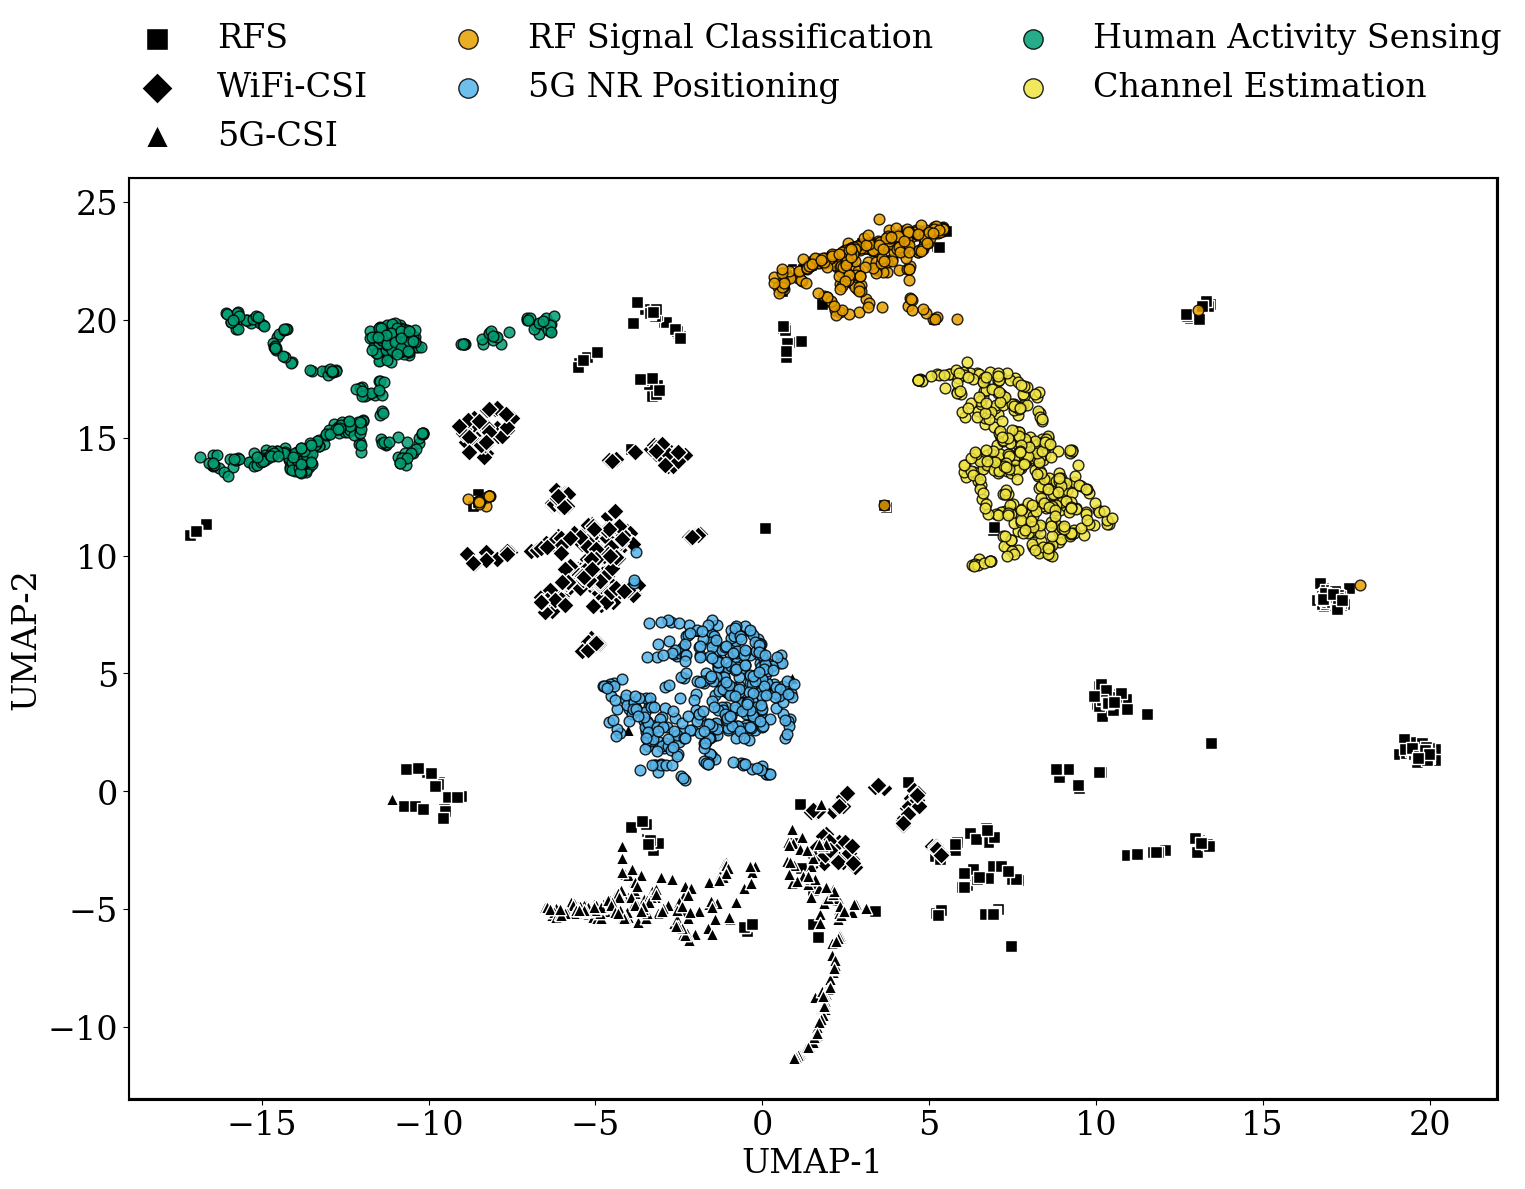

In [36]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as patches


plt.rcParams['font.family'] = 'serif'
fontsize = 24
tick_fontsize = 24

# Colored for downstream
downstream_colors = ['#E69F00', '#56B4E9', '#009E73', '#F0E442', '#0072B2', '#D55E00']
downstream_tasks = [
    "rf_classification", "positioning", "sensing", "channel_estimation"
]
downstream_color_map = {lbl: downstream_colors[i % len(downstream_colors)] for i, lbl in enumerate(downstream_tasks)}

pretrain_sets = ["RFS", "WiFi-CSI", "5G-CSI"]
pretrain_markers = ["s", "D", "^"]  # Square, diamond, plus (pick shapes you like)

nice_name = {
    "RFS":                "RFS",
    "WiFi-CSI":           "WiFi‑CSI",
    "5G-CSI":             "5G‑CSI",
    "rf_classification":  "RF Signal Classification",
    "positioning":        "5G NR Positioning",
    "sensing":            "Human Activity Sensing",
    "channel_estimation": "Channel Estimation",
}

fig, ax = plt.subplots(figsize=(16, 12))
marker_size_pre = 80
marker_size_down = 60

# Plot pretraining sets (all black, different shapes)
for i, lbl in enumerate(pretrain_sets):
    idx = np.where(np.array(all_labels) == lbl)[0]
    ax.scatter(
        emb_2d[idx, 0], emb_2d[idx, 1],
        s=marker_size_pre,
        alpha=1.0,
        facecolors='black',
        edgecolor='white',
        marker=pretrain_markers[i % len(pretrain_markers)],
        label=f"Pretrain: {nice_name[lbl]}",
        linewidths=1,
    )

# Plot downstream sets (colored, all circles)
for lbl in downstream_tasks:
    idx = np.where(np.array(all_labels) == lbl)[0]
    ax.scatter(
        emb_2d[idx, 0], emb_2d[idx, 1],
        s=marker_size_down,
        alpha=0.85,
        facecolors=downstream_color_map[lbl],
        edgecolor='black',
        marker='o',
        label=f"Downstream: {nice_name[lbl]}",
        linewidths=1,
    )

ax.set_xlabel("UMAP‑1", fontsize=fontsize, color='black')
ax.set_ylabel("UMAP‑2", fontsize=fontsize, color='black')
ax.tick_params(axis='both', labelsize=tick_fontsize, colors='black')
for spine in ax.spines.values():
    spine.set_color('black')

# Custom legend: remove duplicates, group pretrain/downstream
# -------- legend placement & de-duplication -------------
handles, labels = ax.get_legend_handles_labels()

# keep a single handle per label
uniq = dict(zip(labels, handles))          # preserves insertion order (Py ≥3.7)
uniq_lbls, uniq_hnds = list(uniq.keys()), list(uniq.values())

ax.legend(
    uniq_hnds,
    [l.replace("Pretrain: ", "").replace("Downstream: ", "") for l in uniq_lbls],
    loc="upper center",
    bbox_to_anchor=(0.5, 1.20),   # 0.5 = centered; 1.20 = just above the axes
    ncol=3,                       # two columns; change to 3 if you prefer
    fontsize=fontsize,
    markerscale=1.8,
    frameon=False,
)

for spine in ax.spines.values():
    spine.set_color('black')

rect = patches.Rectangle((0, 0), 1, 1, transform=ax.transAxes,
                         fill=False, edgecolor='black', linewidth=3)
ax.add_patch(rect)
# leave a bit of head-room for the legend
# handles, labels = ax.get_legend_handles_labels()
# pre_handles = [h for h, l in zip(handles, labels) if l.startswith("Pretrain")]
# down_handles = [h for h, l in zip(handles, labels) if l.startswith("Downstream")]
# ax.legend(pre_handles + down_handles, [l.replace("Pretrain: ", "").replace("Downstream: ", "") for l in (labels)], loc="right", ncol=1, bbox_to_anchor=(1.5, 0.5), fontsize=16, markerscale=1.7, frameon=True)

plt.tight_layout()
plt.savefig("Figures/fig_pca_umap_2d.png", dpi=300, bbox_inches="tight")
plt.show()

## Reduce Dim (3D)

In [25]:
all_embeds = []
all_labels = []
for name, e in embeddings.items():              # e: (400, 512) on GPU
    all_embeds.append(e.cpu().numpy())         # move → CPU, ndarray
    all_labels.extend([name] * e.shape[0])

all_embeds = np.vstack(all_embeds)             # (N_total, 512)

# ---- 2. fit UMAP (2‑D) ----
n_neighbours = 15
min_dist = 0.1
reducer_3d = umap.UMAP(n_components=3, n_neighbors=n_neighbours, min_dist=min_dist, metric="cosine", random_state=0, densmap=True)
X50 = PCA(50).fit_transform(all_embeds)
emb_3d = reducer_3d.fit_transform(X50)     # (N_total, 2)

# perplexity = 1000   # empirical safe choice
# tsne3d = TSNE(n_components=3,
#               perplexity=perplexity,
#               metric="cosine",
#               init="pca",
#               learning_rate="auto",
#               random_state=0).fit_transform(all_embeds)

C:\Users\ahmed\PycharmProjects\QoherentLnC_V2\.venv\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


## Plot 3D

C:\Users\ahmed\AppData\Local\Temp\ipykernel_29320\2070058589.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette       = plt.cm.get_cmap("tab10", len(unique_labels))


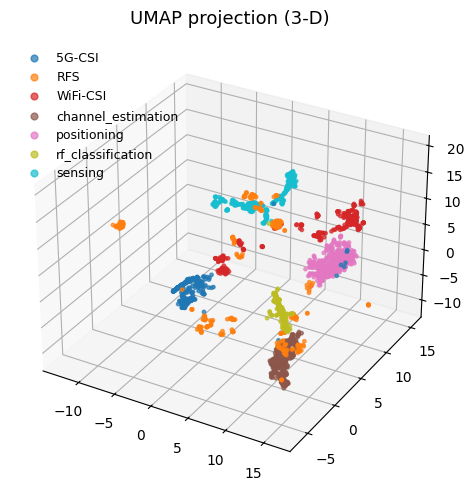

In [26]:
unique_labels = sorted(set(all_labels))
palette       = plt.cm.get_cmap("tab10", len(unique_labels))

fig = plt.figure(figsize=(7, 5))
ax  = fig.add_subplot(111, projection="3d")

for i, lbl in enumerate(unique_labels):
    idx = np.where(np.array(all_labels) == lbl)[0]
    ax.scatter(
        emb_3d[idx, 0],
        emb_3d[idx, 1],
        emb_3d[idx, 2],
        s=6,
        alpha=0.7,
        color=palette(i),
        label=lbl,
    )

ax.set_title("UMAP projection (3‑D)", fontsize=13, pad=12)
# ax.set_axis_off()                              # cleaner look
ax.legend(markerscale=2, fontsize=9, frameon=False, loc="upper left")

plt.tight_layout()
plt.savefig("Figures/umap_3d.png", dpi=300)
plt.show()

(2800, 3)